# PDE-FIND for the Quantum Harmonic Oscillator

By Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on the schrodinger equation with a parabolic well potential.  
$$
iu_t = \frac{-1}{2}u_{xx} + \frac{x^2}{2}u
$$
We assume full knowledge of the complex wave function rather than just the squared magnitude and also know that there is a potenital function $\frac{x^2}{2}$, but it is unknown if or how it appears in the PDE.

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.rcParams['axes.titlesize']= 'medium'
import numpy as np 
from mpl_toolkits.mplot3d import Axes3D
import PDE_FIND 
import scipy.io as sio
import timeit
import imp
%config InlineBackend.figure_formats = ['svg'] 

def Error(ut,X,w):
    return np.linalg.norm(ut[:,0]-np.sum([w[i]*X.T[i] for i in range(len(w))],axis=0))

def MattSTRidge(R, Ut, lam, tol, STR_iters = 25, normalize = 2, split = 0.8):

    # Split data into 80% training and 20% test, then search for the best tolerance.
    np.random.seed(0) # for consistancy
    n,_ = R.shape
    train = np.random.choice(n, int(n*split), replace = False)
    test = [i for i in np.arange(n) if i not in train]
    TrainR = R[train,:]
    TestR = R[test,:]
    TrainY = Ut[train,:]
    TestY = Ut[test,:]
    D = TrainR.shape[1] 
    
    # Get a set of coefficients and error
    w = PDE_FIND.STRidge(TrainR,TrainY,lam,STR_iters,tol,normalize = normalize)
    err = np.linalg.norm(TestY - TestR.dot(w), 2)
    
    return w, err

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load data - solution to schrodinger in parabolic well
data = sio.loadmat('harmonic_osc.mat')
np.random.seed(1)
u = data['usol'][::2,::2]
#Adding some noise to the data. Maybe this is not the best kind of noise for our purposes...
u = u + 0.0*np.random.randn(u.shape[0], u.shape[1])
x = data['x'][0][::2]
t = data['t'][:,0][::2]
dt = t[1] - t[0]
dx = x[1] - x[0]
n = len(x)
m = len(t)

In [3]:
potential = np.vstack([0.5*np.power(x,2).reshape((1,n)) for _ in range(m)])

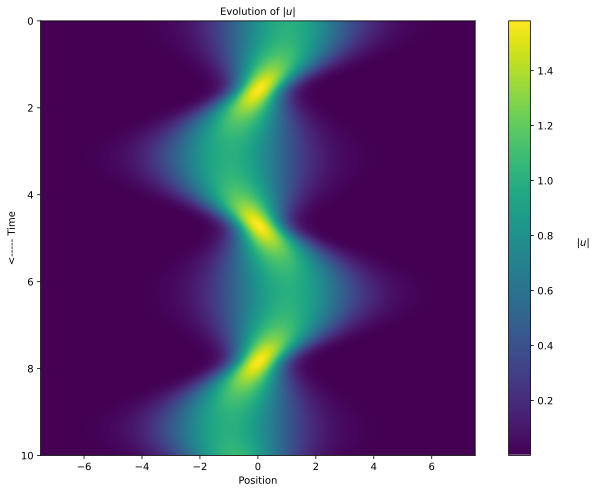

In [4]:
plt.imshow(abs(u),extent=(-7.5,7.5,10,0),aspect=1.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('$|u|$', rotation=0)
plt.xlabel("Position")
plt.ylabel("<----- Time")
plt.title("Evolution of $|u|$")
plt.show()

## Build Library of Candidate Terms

We first differentiate the data along the spatial and temporal directions and construct a library of terms including nonlinearities and partial derivatives.  The matrix Theta is constructed so that each column is a potential term in the PDE, listed below.

ZGN: To use the polynomial interpolation differentiation rather than the finite differences with noise, we would need to split the real and imaginary parts up, since PolyDiff expects real input. Can we do coupled fields in PDE_FIND?

In [5]:
start=timeit.default_timer()

ut = np.zeros((m,n), dtype=np.complex64)
ux = np.zeros((m,n), dtype=np.complex64)
uxx = np.zeros((m,n), dtype=np.complex64)
uxxx = np.zeros((m,n), dtype=np.complex64)

for i in range(n):
    ut[:,i] = PDE_FIND.FiniteDiff(u[:,i], dt, 1)
for i in range(m):
    ux[i,:] = PDE_FIND.FiniteDiff(u[i,:], dx, 1)
    uxx[i,:] = PDE_FIND.FiniteDiff(u[i,:], dx, 2)
    uxxx[i,:] = PDE_FIND.FiniteDiff(u[i,:], dx, 3)
    
ut = np.reshape(ut, (n*m,1), order='F')
ux = np.reshape(ux, (n*m,1), order='F')
uxx = np.reshape(uxx, (n*m,1), order='F')
uxxx = np.reshape(uxxx, (n*m,1), order='F')
X_ders = np.hstack([np.ones((n*m,1)),ux,uxx,uxxx])
X_data = np.hstack([np.reshape(u, (n*m,1), order='F'), 
                    np.reshape(abs(u), (n*m,1), order='F'), 
                    np.reshape(potential, (n*m,1), order='F')])
derivatives_description = ['','u_{x}','u_{xx}', 'u_{xxx}']

X, descr = PDE_FIND.build_Theta(X_data, X_ders, derivatives_description, 2, data_description = ['u','|u|','V'])

stop=timeit.default_timer()
print("Runtime:", stop-start)

Runtime: 16.975204011891037


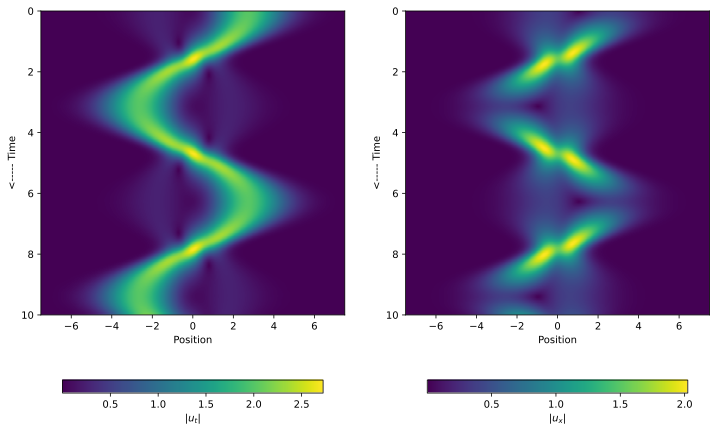

In [6]:
plt.subplots(1,2)

plt.subplot(1,2,1)
plt.imshow(np.abs(np.reshape(ut,(m,n),order='F')),extent=(-7.5,7.5,10,0),aspect=1.5)
cbar = plt.colorbar(fraction=0.03,orientation="horizontal")
cbar.ax.set_xlabel('$|u_t|$', rotation=0)
plt.xlabel("Position")
plt.ylabel("<----- Time")

plt.subplot(1,2,2)
plt.imshow(np.abs(np.reshape(ux,(m,n),order='F')),extent=(-7.5,7.5,10,0),aspect=1.5)
cbar = plt.colorbar(fraction=0.03,orientation="horizontal")
cbar.ax.set_xlabel('$|u_x|$', rotation=0)
plt.xlabel("Position")
plt.ylabel("<----- Time")


plt.show()

## Parameter Sweep over $\lambda$ with Fixed d_tol. Trained on all data (i.e. train + test).

In [7]:
imp.reload(PDE_FIND)

start=timeit.default_timer()

ErrorData=[]
# Iterate over lambda (range found to be reasonably good via trial and error)
for _ in np.linspace(0.001,0.05,25):
    print(_)
    
    # Call TrainSTRidge with fixed tolerance
    temp=PDE_FIND.TrainSTRidge(X,ut,_,10)
    
    # Save number of nonzero terms, test error, lambda, training error
    ErrorData.append([np.count_nonzero(temp[0]),temp[1],_,temp[2]])

ErrorData=np.array(ErrorData)
stop=timeit.default_timer()
print("Runtime:", stop-start)

0.001


/home/zackn/manybody/PDE_FIND.py:437: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
/home/zackn/manybody/PDE_FIND.py:584: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
/home/zackn/manybody/PDE_FIND.py:610: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning 

0.003041666666666667
0.005083333333333334
0.007125
0.009166666666666667
0.011208333333333334
0.013250000000000001
0.015291666666666669
0.017333333333333336
0.019375000000000003
0.02141666666666667
0.023458333333333338
0.025500000000000002
0.02754166666666667
0.029583333333333336
0.031625
0.03366666666666667
0.035708333333333335
0.037750000000000006
0.03979166666666667
0.04183333333333334
0.043875000000000004
0.045916666666666675
0.04795833333333334
0.05
Runtime: 73.21698010386899


In [8]:
PDE_FIND.print_pde(PDE_FIND.TrainSTRidge(X,ut,0.01,10)[0],descr)

u_t = (-0.000013 +0.495790i)u_{xx}
    + (-0.000013 -0.989719i)uV
   


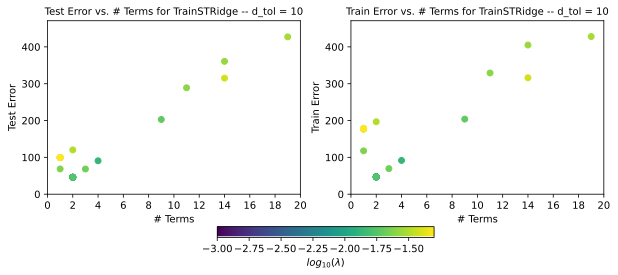

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

plot=ax[0].scatter(ErrorData[:,0],ErrorData[:,1],c=np.log10(ErrorData[:,2]))
ax[0].set_xlabel("# Terms")
ax[0].set_ylabel("Test Error")
ax[0].set_title("Test Error vs. # Terms for TrainSTRidge -- d_tol = 10")
ax[0].set_xticks(range(0,22,2))
ax[0].set_ylim([0,1.1*np.max(ErrorData[:,[1,3]])])

plot=ax[1].scatter(ErrorData[:,0],ErrorData[:,3],c=np.log10(ErrorData[:,2]))
ax[1].set_xlabel("# Terms")
ax[1].set_ylabel("Train Error")
ax[1].set_title("Train Error vs. # Terms for TrainSTRidge -- d_tol = 10")
ax[1].set_xticks(range(0,22,2))
ax[1].set_ylim([0,1.1*np.max(ErrorData[:,[1,3]])])


cbar = fig.colorbar(plot, ax=ax.ravel().tolist(),orientation="horizontal",fraction=0.05)
cbar.ax.set_xlabel('$log_{10}(\lambda)$')

plt.show()

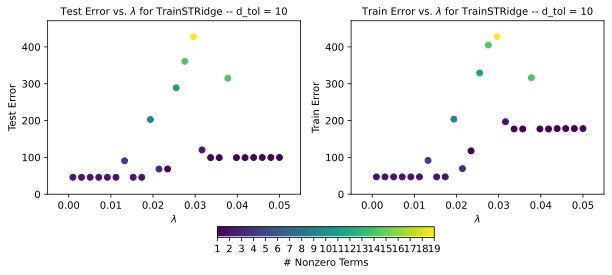

In [10]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].scatter(ErrorData[:,2],ErrorData[:,1],c=ErrorData[:,0])
ax[0].set_xlabel("$\lambda$")
ax[0].set_ylabel("Test Error")
ax[0].set_title("Test Error vs. $\lambda$ for TrainSTRidge -- d_tol = 10")
ax[0].set_xlim([-0.005,0.055])
ax[0].set_ylim([0,1.1*np.max(ErrorData[:,[1,3]])])


plot=ax[1].scatter(ErrorData[:,2],ErrorData[:,3],c=ErrorData[:,0])
ax[1].set_xlabel("$\lambda$")
ax[1].set_ylabel("Train Error")
ax[1].set_title("Train Error vs. $\lambda$ for TrainSTRidge -- d_tol = 10")
ax[1].set_xlim([-0.005,0.055])
ax[1].set_ylim([0,1.1*np.max(ErrorData[:,[1,3]])])

cbar = fig.colorbar(plot, ax=ax.ravel().tolist(),orientation="horizontal",fraction=0.05)
cbar.ax.set_xlabel('# Nonzero Terms')
cbar.set_ticks(np.arange(0,25,1))

plt.show()

## Repeat Parameter Sweep, but Only Train on Training Data

In [11]:
def TrainSTRidge2(R, Ut, lam, d_tol, maxit = 25, STR_iters = 10, l0_penalty = None, normalize = 2, split = 0.8, print_best_tol = False):
    """
    This function trains a predictor using STRidge.

    It runs over different values of tolerance and trains predictors on a training set, then evaluates them 
    using a loss function on a holdout set.

    Please note published article has typo.  Loss function used here for model selection evaluates fidelity using 2-norm,
    not squared 2-norm.
    """

    # Split data into 80% training and 20% test, then search for the best tolerance.
    np.random.seed(0) # for consistancy
    n,_ = R.shape
    train = np.random.choice(n, int(n*split), replace = False)
    test = [i for i in np.arange(n) if i not in train]
    TrainR = R[train,:]
    TestR = R[test,:]
    TrainY = Ut[train,:]
    TestY = Ut[test,:]
    D = TrainR.shape[1]       

    # Set up the initial tolerance and l0 penalty –– NOTE: This is the "L"0 penalty, not the "ten" penalty!!
    d_tol = float(d_tol)
    tol = d_tol
    if l0_penalty == None: l0_penalty = 0.001*np.linalg.cond(R)

    # Get the standard least squares estimator
    w = np.zeros((D,1))
    w_best = np.linalg.lstsq(TrainR, TrainY)[0]
    err_best = np.linalg.norm(TestY - TestR.dot(w_best), 2) + l0_penalty*np.count_nonzero(w_best)
    tol_best = 0

    # Now increase tolerance until test performance decreases
    for iter in range(maxit):

        #print(f"TrainSTRidge iteration {iter}: tol = {tol}")
        
        # Get a set of coefficients and error
        w = PDE_FIND.STRidge(TrainR,TrainY,lam,STR_iters,tol,normalize = normalize)
        err = np.linalg.norm(TestY - TestR.dot(w), 2) + l0_penalty*np.count_nonzero(w)

        # Has the accuracy improved?
        if err <= err_best:
            err_best = err
            w_best = w
            tol_best = tol
            tol = tol + d_tol

        else:
            tol = max([0,tol - 2*d_tol])
            d_tol  = 2*d_tol / (maxit - iter)
            tol = tol + d_tol

    if print_best_tol: print("Optimal tolerance: %f"%(tol_best))

    return w_best, err_best, np.linalg.norm(TrainY - TrainR.dot(w_best), 2) + l0_penalty*np.count_nonzero(w_best)


In [12]:
imp.reload(PDE_FIND)

start=timeit.default_timer()

ErrorData2=[]
for _ in np.linspace(0.001,0.05,25):
    print(_)
    temp=TrainSTRidge2(X,ut,_,10)
    ErrorData2.append([np.count_nonzero(temp[0]),temp[1],_,temp[2]])
stop=timeit.default_timer()

ErrorData2=np.array(ErrorData2)
stop=timeit.default_timer()
print("Runtime:", stop-start)

0.001


/tmp/ipykernel_2559752/2946063506.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]


0.003041666666666667
0.005083333333333334
0.007125
0.009166666666666667
0.011208333333333334
0.013250000000000001
0.015291666666666669
0.017333333333333336
0.019375000000000003
0.02141666666666667
0.023458333333333338
0.025500000000000002
0.02754166666666667
0.029583333333333336
0.031625
0.03366666666666667
0.035708333333333335
0.037750000000000006
0.03979166666666667
0.04183333333333334
0.043875000000000004
0.045916666666666675
0.04795833333333334
0.05
Runtime: 56.18102704081684


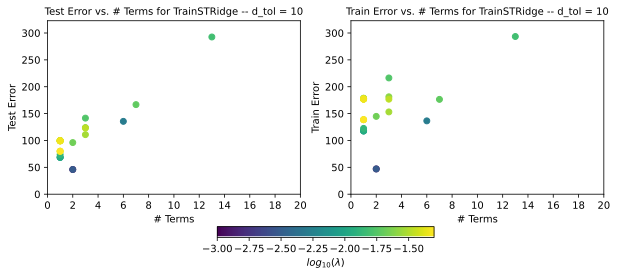

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

plot=ax[0].scatter(ErrorData2[:,0],ErrorData2[:,1],c=np.log10(ErrorData2[:,2]))
ax[0].set_xlabel("# Terms")
ax[0].set_ylabel("Test Error")
ax[0].set_title("Test Error vs. # Terms for TrainSTRidge -- d_tol = 10")
ax[0].set_xticks(range(0,22,2))
ax[0].set_ylim([0,1.1*np.max(ErrorData2[:,[1,3]])])

plot=ax[1].scatter(ErrorData2[:,0],ErrorData2[:,3],c=np.log10(ErrorData2[:,2]))
ax[1].set_xlabel("# Terms")
ax[1].set_ylabel("Train Error")
ax[1].set_title("Train Error vs. # Terms for TrainSTRidge -- d_tol = 10")
ax[1].set_xticks(range(0,22,2))
ax[1].set_ylim([0,1.1*np.max(ErrorData2[:,[1,3]])])


cbar = fig.colorbar(plot, ax=ax.ravel().tolist(),orientation="horizontal",fraction=0.05)
cbar.ax.set_xlabel('$log_{10}(\lambda)$')

plt.show()

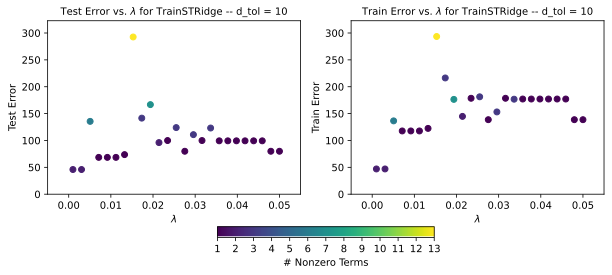

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].scatter(ErrorData2[:,2],ErrorData2[:,1],c=ErrorData2[:,0])
ax[0].set_xlabel("$\lambda$")
ax[0].set_ylabel("Test Error")
ax[0].set_title("Test Error vs. $\lambda$ for TrainSTRidge -- d_tol = 10")
ax[0].set_xlim([-0.005,0.055])
ax[0].set_ylim([0,1.1*np.max(ErrorData2[:,[1,3]])])


plot=ax[1].scatter(ErrorData2[:,2],ErrorData2[:,3],c=ErrorData2[:,0])
ax[1].set_xlabel("$\lambda$")
ax[1].set_ylabel("Train Error")
ax[1].set_title("Train Error vs. $\lambda$ for TrainSTRidge -- d_tol = 10")
ax[1].set_xlim([-0.005,0.055])
ax[1].set_ylim([0,1.1*np.max(ErrorData2[:,[1,3]])])

cbar = fig.colorbar(plot, ax=ax.ravel().tolist(),orientation="horizontal",fraction=0.05)
cbar.ax.set_xlabel('# Nonzero Terms')
cbar.set_ticks(np.arange(0,25,1))

plt.show()